In [1]:
!pip install tensorflow
!pip install faiss-cpu

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import faiss
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.random_projection import SparseRandomProjection
import os
import pandas as pd
from PIL import Image
import kagglehub

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
harbhajansingh21_german_traffic_sign_dataset_path = kagglehub.dataset_download('harbhajansingh21/german-traffic-sign-dataset')

print('Data source import complete.')


Data source import complete.


In [4]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load pickled data
import pickle
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.io.parsers import read_csv


## Loading datasets
training_file = '/kaggle/input/german-traffic-sign-dataset/train.p'
validation_file='/kaggle/input/german-traffic-sign-dataset/valid.p'
testing_file = '/kaggle/input/german-traffic-sign-dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

sign_names = read_csv("/kaggle/input/german-traffic-sign-dataset/signname.csv").values[:, 1]

#Separating features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
# Number of training examples
n_train = X_train.shape[0]
# Number of validation examples
n_validation = X_valid.shape[0]
# Number of testing examples.
n_test = X_test.shape[0]
# What's the shape of an traffic sign image?
image_shape = X_train[0].shape
# Unique classes/labels there are in the dataset.
classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
n_classes = len(class_counts)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


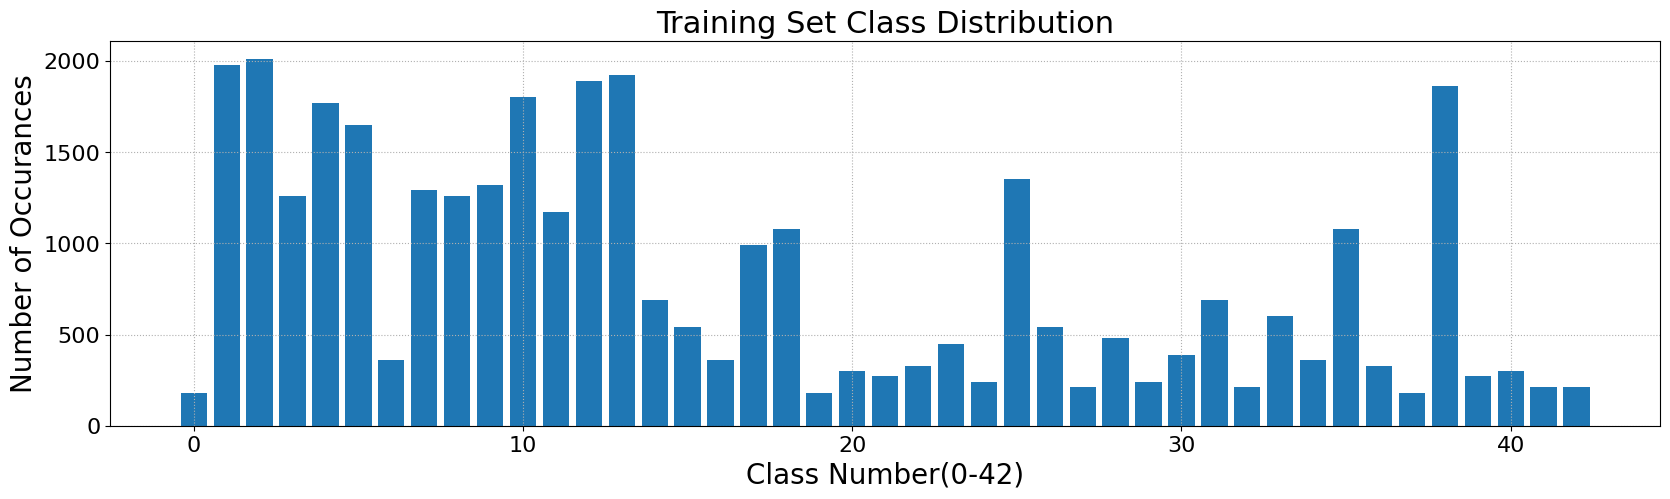

In [6]:
#Plot to show frequencies of data for Training dataset
plt.figure(0, figsize = (20,5))
unique_train, counts_train = np.unique(y_train, return_counts = True)
plt.bar(unique_train, counts_train)

plt.title('Training Set Class Distribution', fontsize=22)
plt.xlabel('Class Number(0-42)', fontsize=20)
plt.ylabel('Number of Occurances', fontsize=20)
plt.tick_params(labelsize=16)
plt.grid(linestyle=':')


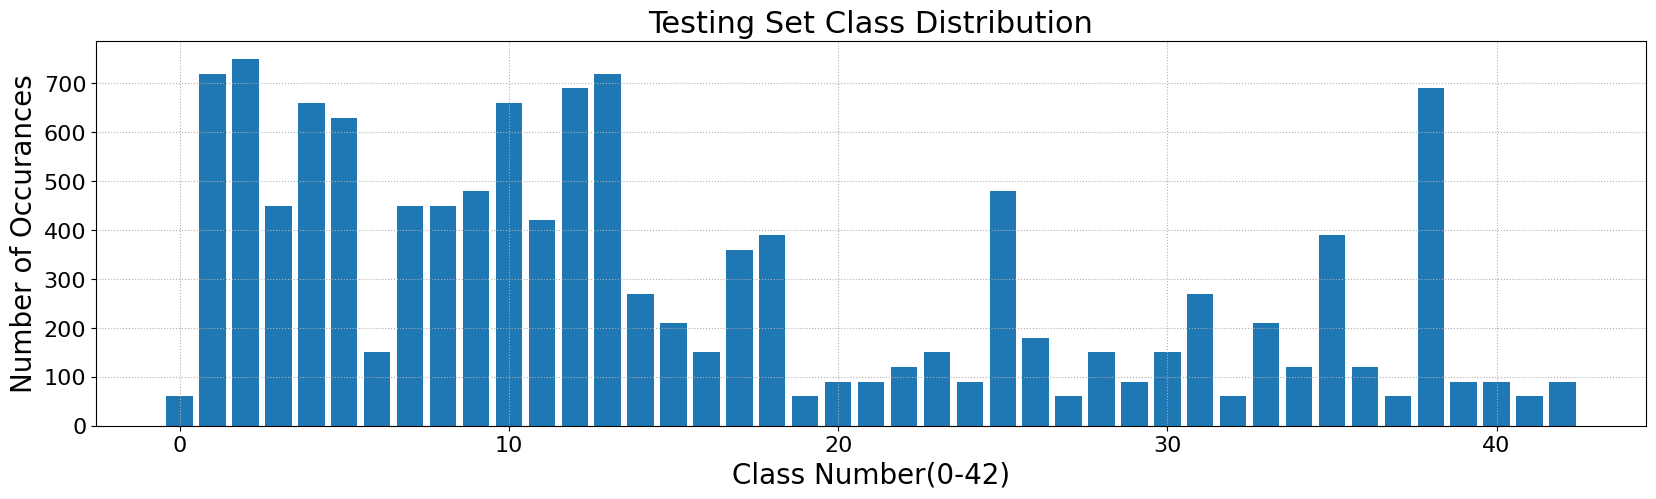

In [7]:
#Plot to show frequencies of data for Testing dataset
plt.figure(0, figsize = (20,5))
unique_test, counts_test = np.unique(y_test, return_counts = True)
plt.bar(unique_test, counts_test)

plt.title('Testing Set Class Distribution', fontsize=22)
plt.xlabel('Class Number(0-42)', fontsize=20)
plt.ylabel('Number of Occurances', fontsize=20)
plt.tick_params(labelsize=16)
plt.grid(linestyle=':')


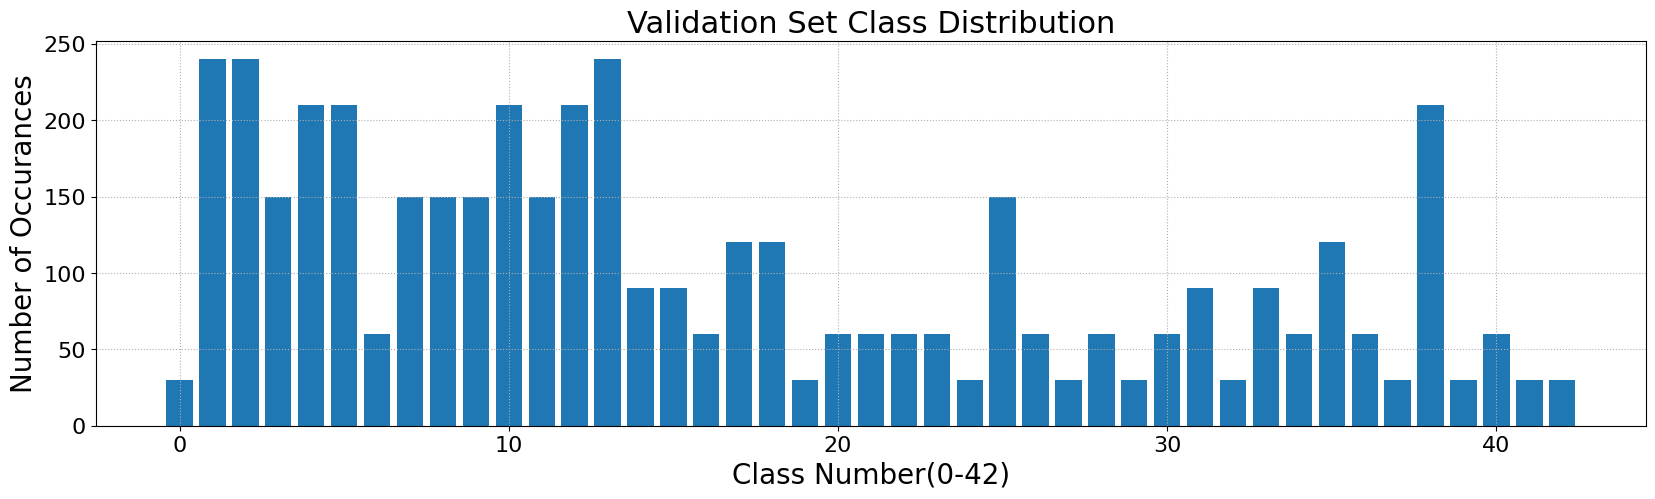

In [8]:
#Plot to show frequencies of data for Validation dataset
plt.figure(0, figsize = (20,5))
unique_valid, counts_valid = np.unique(y_valid, return_counts = True)
plt.bar(unique_valid, counts_valid)

plt.title('Validation Set Class Distribution', fontsize=22)
plt.xlabel('Class Number(0-42)', fontsize=20)
plt.ylabel('Number of Occurances', fontsize=20)
plt.tick_params(labelsize=16)
plt.grid(linestyle=':')


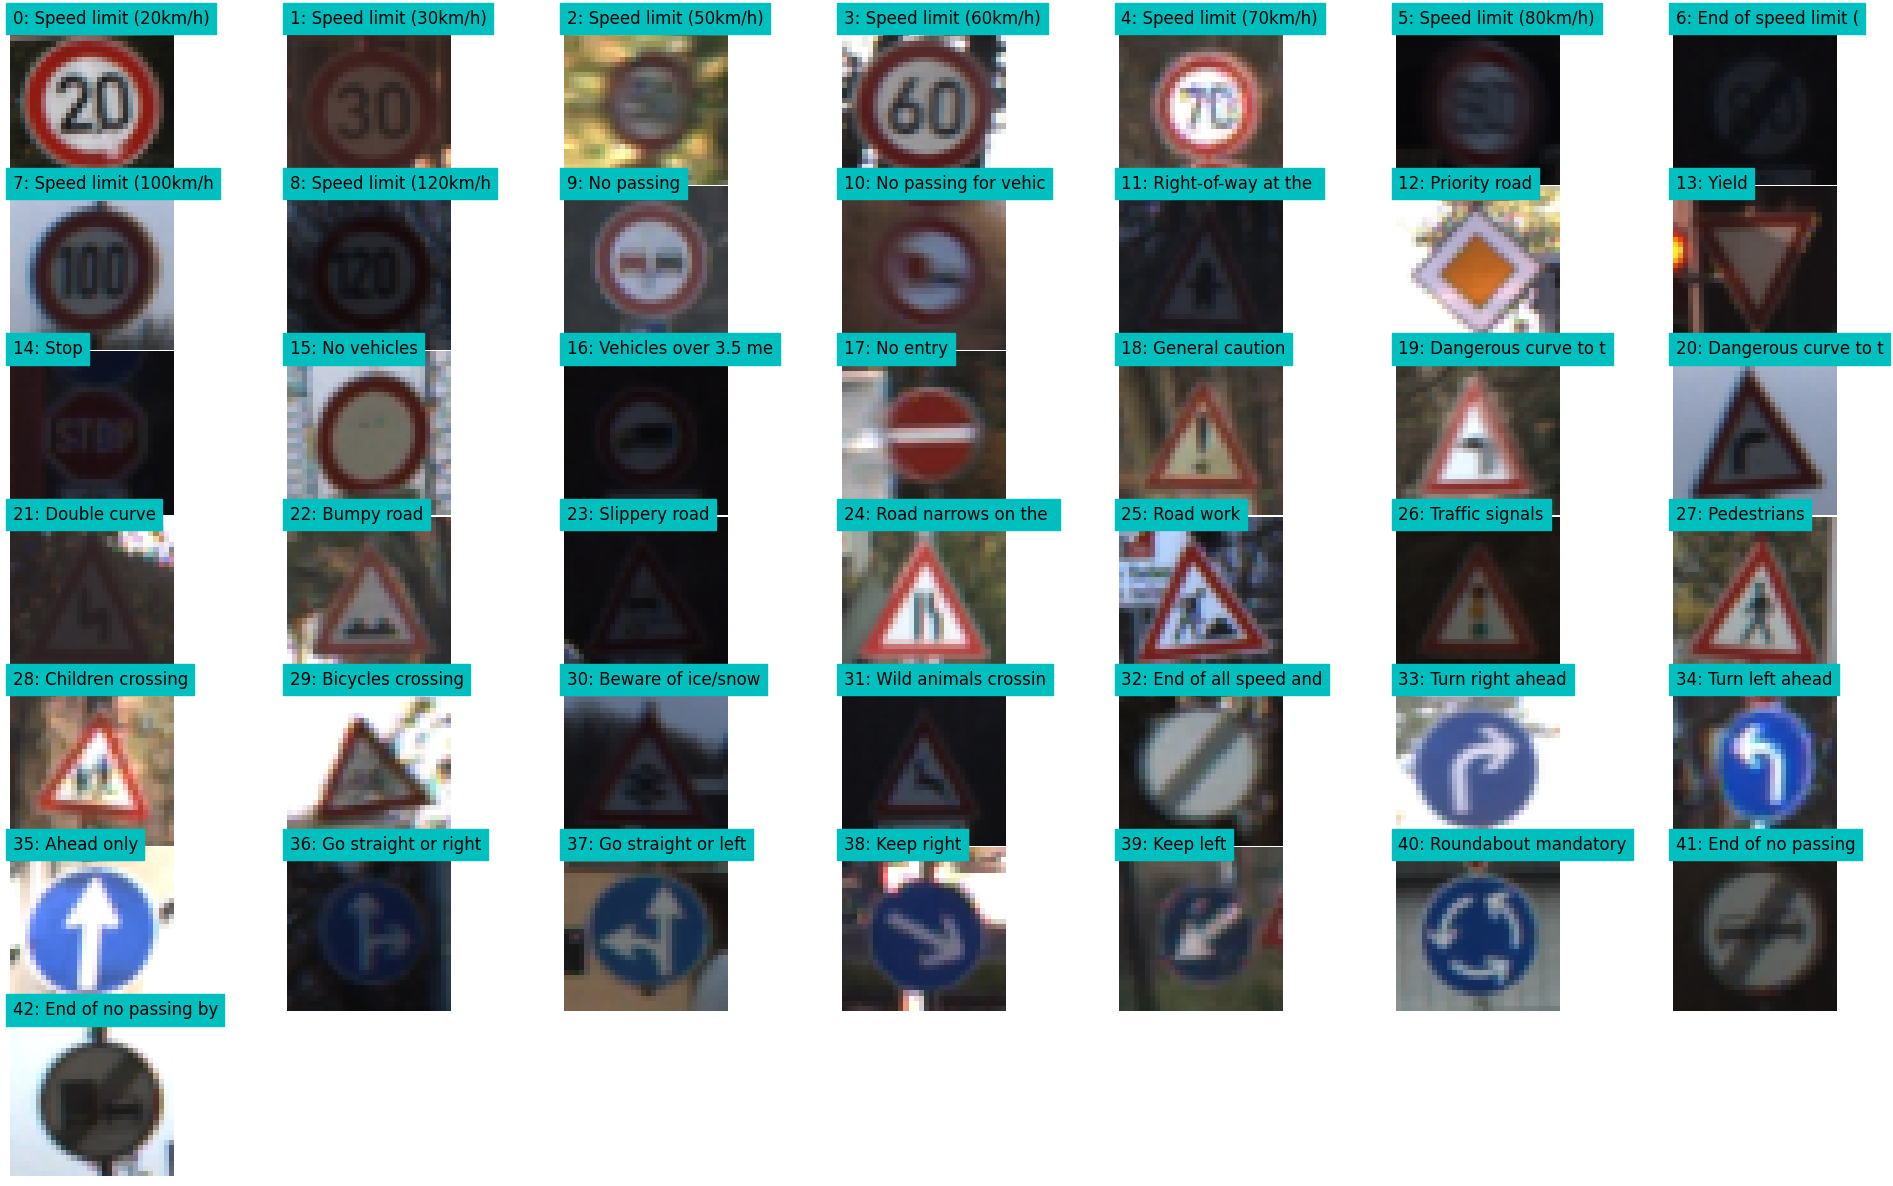

In [9]:
#Showing Random image datasets for each class
def plot_random_each_class(n_row,n_col,X,y):

    plt.figure(figsize = (25,15))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes.

    for c, c_i, c_count in zip(classes, class_indices, class_counts):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[c])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(c_i, c_i+c_count)
        plt.imshow(X[ind_plot])
        #plt.text(2,4,str(y[ind_plot]),color='k',backgroundcolor='c', fontsize=15)
        plt.text(0, 0, '{}: {:.20}'.format(c, sign_names[c]), color='k',backgroundcolor='c', fontsize=12)

        plt.axis('off')
    plt.show()

plot_random_each_class(7,7,X_train,y_train)

In [10]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import cv2

def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=32, width=32):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans

def projection_transform(image, max_warp=0.8, height=32, width=32):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)

    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin

    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image


def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)


def augment_and_balance_data(X_train, y_train, no_examples_per_class =5000):

    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    height, width, channels = X_train[0].shape


    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = y_train.dtype)


    for c, count in zip(range(n_classes), class_counts):
        ##Copy over the current data for the given class
        X_orig = X_train[y_train == c]
        y_orig = y_train[y_train == c]
        ##Add original data to the new dataset
        X_balance = np.append(X_balance, X_orig, axis=0)
        print(c,count)
        temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
        for i in range(n_examples - count):
            temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))


        X_balance = np.append(X_balance,temp_X, axis=0)
        n_added_ex = X_balance.shape[0] - y_balance.shape[0]
        y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =int))


    return X_balance.astype(np.uint8), y_balance



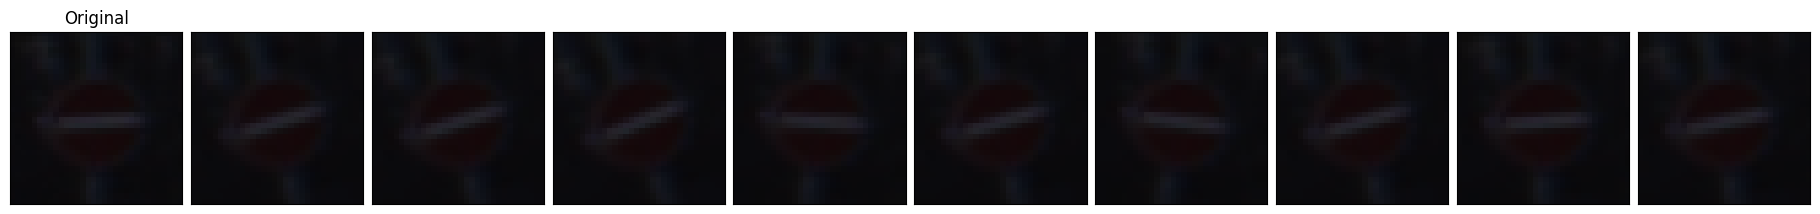

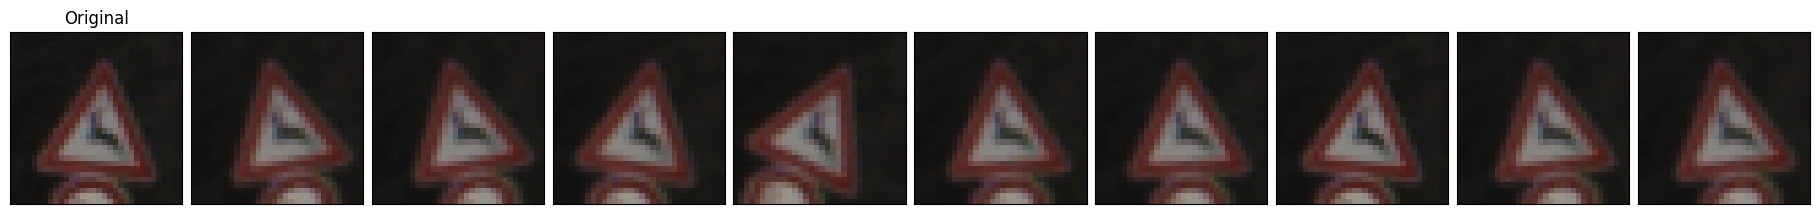

In [11]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (18, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:
            axis.imshow(rotate_image(X_train[image[j],:,:,:], 20))
    pyplot.show()

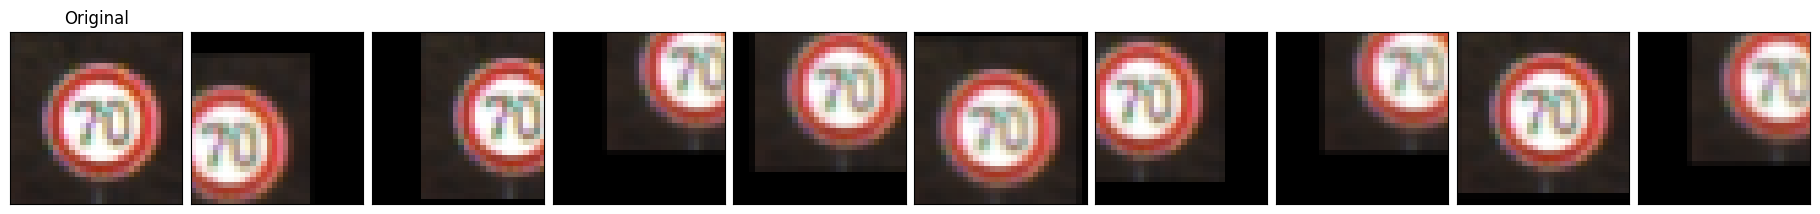

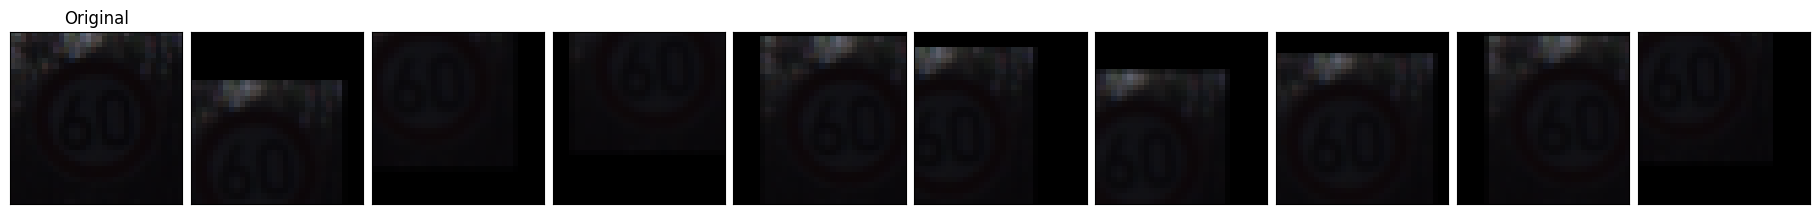

In [12]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (18, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:
            axis.imshow(translate_image(X_train[image[j],:,:,:], 20))
    pyplot.show()

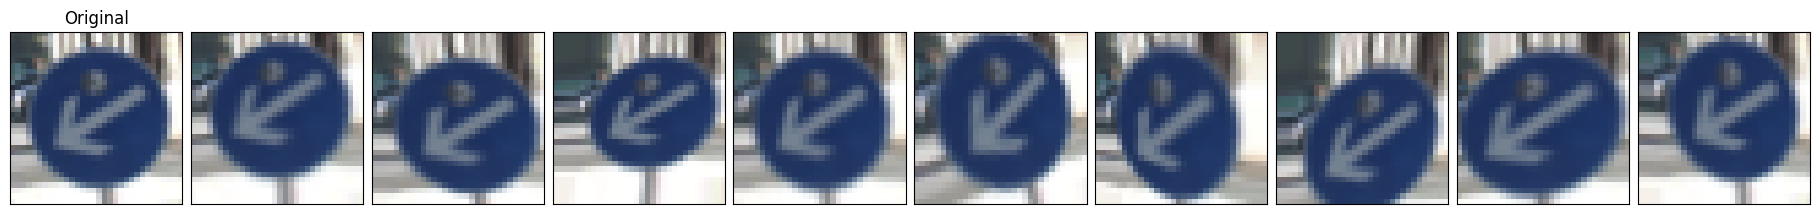

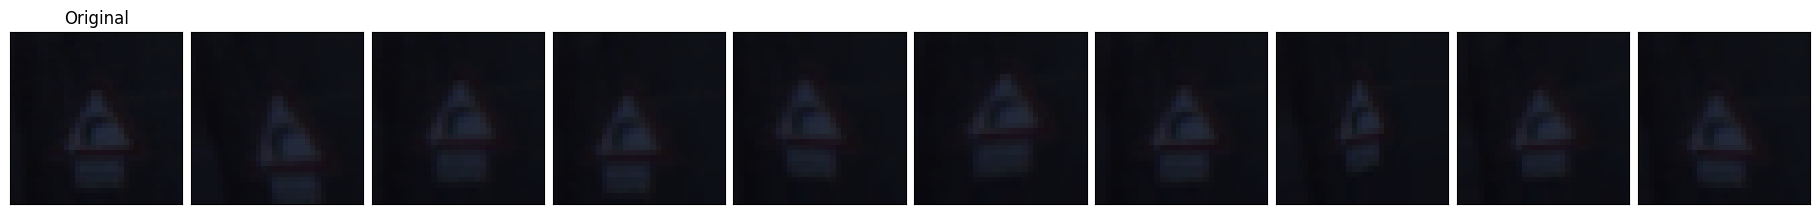

In [13]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (18, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:
            axis.imshow(projection_transform(X_train[image[j],:,:,:]))
    pyplot.show()

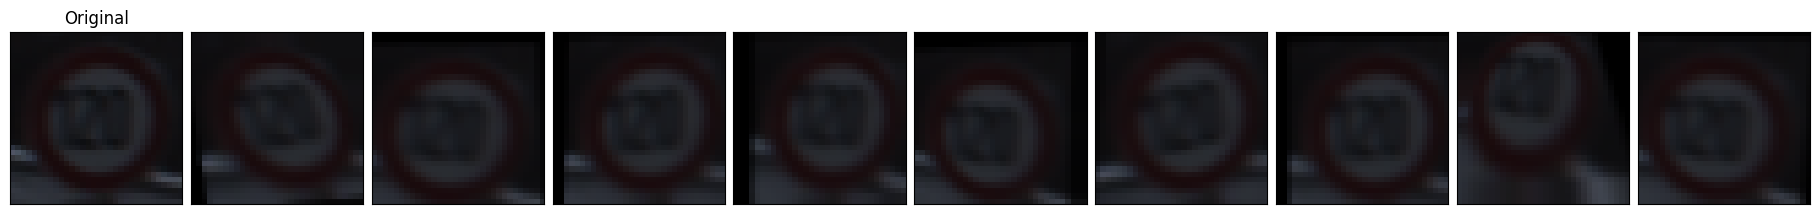

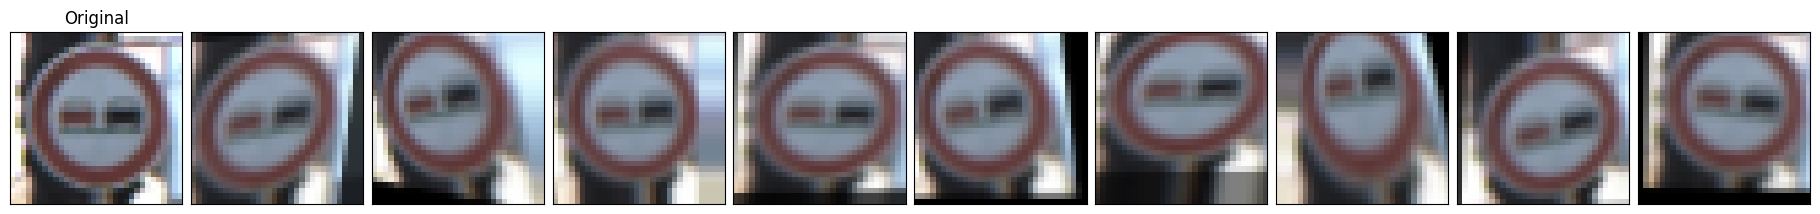

In [14]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (18, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:
            axis.imshow(transform_image(X_train[image[j],:,:,:]))
    pyplot.show()

In [15]:
from sklearn.utils import shuffle

## Shuffle the dataset
X_train, y_train = shuffle(X_train, y_train)

In [16]:
# Convert RGB images to grayscale for the training set
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)

# Convert RGB images to grayscale for the testing set
X_test_gray  = np.sum(X_test/3, axis=3, keepdims=True)

# Convert RGB images to grayscale for the validation set
X_validation_gray  = np.sum(X_valid/3, axis=3, keepdims=True)


In [17]:
# Normalize the training set of grayscale images
X_train_gray_norm = (X_train_gray - 32) / 32

# Normalize the test set of grayscale images
X_test_gray_norm = (X_test_gray - 32) / 32

# Normalize the validation set of grayscale images
X_validation_gray_norm = (X_validation_gray - 32) / 32


In [18]:
# Onehot Encoding the labels.
from tensorflow.keras.utils import to_categorical

# Store the original labels for future reference
y_train_unchanged = y_train
y_validation_unchanged = y_valid
y_test_unchanged = y_test

# Perform Onehot Encoding on the labels
# Convert the labels from integer representation to binary matrix representation
y_train = to_categorical(y_train)
y_validation = to_categorical(y_valid)
y_test = to_categorical(y_test)


In [19]:
# Shape of Train dataset
X_train.shape

(34799, 32, 32, 3)

In [20]:
# Shape of Test dataset
X_test.shape

(12630, 32, 32, 3)

In [21]:
# Shape of Validation dataset
X_valid.shape

(4410, 32, 32, 3)

In [22]:
# Parameters
epsilon = 1e-4  # Tolerance
t_max = 100     # Max iterations
learning_rate = 0.05  # For gradient descent
w_0 = np.random.randn(3072, 43)  # Initial weights for 43 classes

In [24]:
# Define multiple lambda values to test
lambda_values = [0.1, 0.5, 1.0]  # Different compression factors
history_dict = {}  # To store training histories
test_accuracies = {}  # To store test accuracies

In [25]:
## Tensorflow approach (Uses GPU and significantly speeding up the process)
def compute_gradient_tf(X, y, weights):
    """Computes the gradient of the loss function using TensorFlow."""
    # Convert weights to a TensorFlow variable
    weights_tf = tf.Variable(weights)
    with tf.GradientTape() as tape:
        logits = X @ weights_tf  # Use the TensorFlow variable here
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(y, depth=10), logits=logits
        ))
    gradient = tape.gradient(loss, weights_tf)  # Calculate gradient with respect to the TensorFlow variable
    return gradient.numpy()

In [26]:
# Hashing(dimensionality reduction) and clustering

def lsh_clustering(X, n_clusters, n_bits=32):

    # -------------------------------------------------------------------------------------------------------------------------------
    # Apply random projection (LSH)
    lsh = SparseRandomProjection(n_components=n_bits, random_state=42)
    X_hashed = lsh.fit_transform(X)

    # Normalize hashed vectors
    X_hashed = X_hashed / np.linalg.norm(X_hashed, axis=1, keepdims=True)
    # ----------------------------------------------------------------------------------------------------------------------------

    # Use Faiss with cosine similarity on hashed data
    index = faiss.IndexFlatIP(n_bits)
    X_hashed = X_hashed.astype(np.float32)
    kmeans = faiss.Clustering(n_bits, n_clusters)
    kmeans.verbose = True
    kmeans.niter = 10  # Reduced iterations for speed
    kmeans.train(X_hashed, index)

    centroids_hashed = faiss.vector_to_array(kmeans.centroids).reshape(n_clusters, n_bits)
    D, I = index.search(X_hashed, 1)
    clusters = I.flatten()

    # Compute actual centroids in original space
    centroids = np.zeros((n_clusters, X.shape[1]), dtype=np.float32)
    for i in range(n_clusters):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)

    return centroids, clusters

In [27]:
def faiss_clustering(X_train_normalized, target_clusters):

    # Faiss clustering
    index = faiss.IndexFlatIP(784)
    kmeans = faiss.Clustering(784, target_clusters)
    kmeans.verbose = True
    kmeans.niter = 20
    kmeans.seed = 42
    kmeans.train(X_train_normalized, index)

    # Get cluster assignments and centroids
    centroids_normalized = faiss.vector_to_array(kmeans.centroids).reshape(target_clusters, 784)
    D, I = index.search(X_train_normalized, 1)
    clusters = I.flatten()
    centroids = centroids_normalized * np.linalg.norm(X_train, axis=1).mean()

    return centroids, clusters

In [28]:
# Run for each lambda value
for lambda_val in lambda_values:
    start_time = time.time()
    print(f"\nProcessing lambda = {lambda_val}")

    # Set target clusters based on lambda
    target_clusters = int(len(X_train) * lambda_val)

    # LSH clustering
    # centroids, clusters = lsh_clustering(X_train_normalized, target_clusters)

    # Faiss Clustering
    centroids, clusters = faiss_clustering(X_train_normalized, target_clusters)

    # Extract representative labels
    h_k = np.zeros(len(centroids), dtype=np.uint8)
    for i in range(len(centroids)):
        cluster_labels = y_train[clusters == i]
        if len(cluster_labels) > 0:
            h_k[i] = np.bincount(cluster_labels).argmax()

    # Gradient descent optimization
    weights = w_0.copy()
    for iteration in range(t_max):
        previous_centroids = centroids.copy()
        for cluster_idx in range(len(centroids)):
            cluster_points = X_train[clusters == cluster_idx]
            cluster_labels = y_train[clusters == cluster_idx]
            original_gradient = compute_gradient_tf(cluster_points, cluster_labels, weights)
            compressed_gradient = compute_gradient_tf(centroids[cluster_idx].reshape(1, -1),
                                                    np.array([h_k[cluster_idx]]), weights)
            centroids[cluster_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)

        change = np.max(np.linalg.norm(centroids - previous_centroids, axis=1))
        if change <= epsilon:
            break

    # Assign compressed data
    compressed_X = centroids
    compressed_y = h_k

    # Reshape compressed_X to 2D image format for CNN (28, 28, 1)
    compressed_X_2d = compressed_X.reshape(-1, 28, 28, 1)  # Shape: (target_clusters, 28, 28, 1)
    X_test_2d = X_test.reshape(-1, 28, 28, 1)             # Shape: (10000, 28, 28, 1)


    # model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model on compressed data
    history = model.fit(compressed_X_2d, compressed_y,
                        epochs=10,
                        verbose=1)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test_2d, y_test, verbose=0)

    # Store results
    history_dict[lambda_val] = history.history
    test_accuracies[lambda_val] = test_acc

    end_time = time.time()
    print(f"Lambda {lambda_val} - Time taken: {end_time - start_time:.2f}s, Test accuracy: {test_acc:.4f}")


Processing lambda = 0.1


NameError: name 'X_train_normalized' is not defined

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Loss profiles
plt.subplot(1, 2, 1)
for lambda_val, history in history_dict.items():
    plt.plot(history['loss'], label=f'λ={lambda_val}')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Test accuracies
plt.subplot(1, 2, 2)
plt.bar([str(l) for l in lambda_values], test_accuracies.values())
plt.title('Test Accuracy vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()